## *Import Libraries*

In [ ]:
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras import utils
import time
import tensorflow as tf
import tensorflow_datasets as tfds

from IPython import display

## *Load and prepare Dataset*

In [ ]:
dataset = utils.get_file(
    origin = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip',
    fname = 'digit_dataset',
    cache_dir = './',
    extract = True
)

80429056/80417803 [==============================] - 2s 0us/step


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/datasets/DevanagariHandwrittenCharacterDataset/Train',
    batch_size = 256,
    image_size = (28, 28)
)

dataset

Found 78200 files belonging to 46 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for images, labels in dataset.take(-1):
  train_images = images.numpy()

In [ ]:
train_images.shape

(120, 28, 28, 3)

In [ ]:
(_, _), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images.shape

(10000, 28, 28)

In [ ]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5

In [ ]:
test_images.shape

(10000, 28, 28, 1)

In [ ]:
BATCH_SIZE = 256

In [ ]:
train_images = ds.batch(BATCH_SIZE)

In [ ]:
print(train_images)

<BatchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'image/filename': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>


## *Creating the Generator Model*

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)
  #print(model.output_shape)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides = (2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 3)

  return model

TensorShape([1, 28, 28, 3])

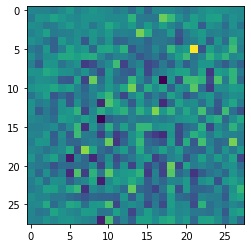

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generated_image.shape

## *Discriminator Model*

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides = (2,2), padding='same', input_shape=[28, 28, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)
discriminator.summary()

tf.Tensor([[0.49902242]], shape=(1, 1), dtype=float32)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 

## *Loss and Optimizers*

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# In order to save and restore models, we use checkpoints
checkpoint_dir = './models_checkpoint_dir'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoint')
checkpoint = tf.train.Checkpoint(
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator
)

## *Training Loop*

In [ ]:
num_epochs = 20
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)

(16, 100)


In [ ]:
@tf.function

def train_step(real_images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(real_images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch_num, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch_num))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time() - start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## *Train the MODEL*

In [ ]:
# train_images.shape
train(train_images, num_epochs)

ValueError: ignored

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## *Display Image*

In [ ]:
def display_image(epoch_num):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_num))

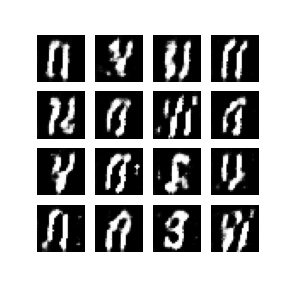

In [ ]:
display_image(50)

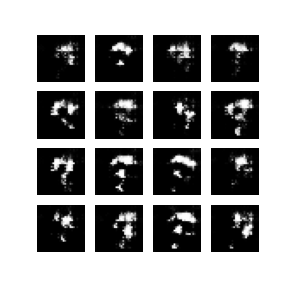

In [ ]:
display_image(25)